In [1]:
from temds import tile
from osgeo import ogr
import geopandas as gpd
import numpy as np
import rioxarray as rio
from temds import worldclim
from temds import crujra
import xarray as xr

from pathlib import Path

from affine import Affine

from temds import downscalers
from temds import corrections

import matplotlib.pyplot as plt


In [2]:
c_tile = (7, 16)
tile_index = gpd.read_file('/media/rwspicer/data/V3/tem/00-aoi/tile-index/')
hdx = tile_index['H'] == c_tile[0]
vdx = tile_index['V'] == c_tile[1]
bounds = tile_index[vdx & hdx].bounds
minx, maxx, miny, maxy = bounds[['minx','maxx','miny','maxy']].iloc[0]
minx, maxx, miny, maxy

(-1678000.0, -1402000.0, 2915000.0, 3315000.0)

In [3]:
wc_arctic = worldclim.WorldClim('/media/rwspicer/data/V3/tem/02-arctic/worldclim/worldclim-arctic.nc')

In [4]:
wc_arctic.dataset.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH],AUTHORITY["EPSG","6931"]]')

In [5]:

annual_list = []
for cru_file in list(Path('/media/rwspicer/data/V3/tem/02-arctic/cru-jra/').glob('*.nc')):
    year = int(cru_file.name.split('.')[-4])
    if year < 1970 or year > 2001:
        continue

    temp = crujra.AnnualDaily(year,cru_file, verbose=False)
    # temp.reproject(tile_index.crs.to_wkt())
    annual_list.append(temp)

annual_list[:5]

[CRUJRAnnualDaily: 1996,
 CRUJRAnnualDaily: 1985,
 CRUJRAnnualDaily: 1998,
 CRUJRAnnualDaily: 1997,
 CRUJRAnnualDaily: 1975]

In [6]:
cru_arctic_ts = crujra.AnnualTimeSeries(annual_list)

In [7]:
cru_arctic_ts[1970:1975]

AnnualTimeSeries
-CRUJRAnnualDaily: 1970
-CRUJRAnnualDaily: 1971
-CRUJRAnnualDaily: 1972
-CRUJRAnnualDaily: 1973
-CRUJRAnnualDaily: 1974

In [8]:
mytile = tile.Tile(c_tile, bounds, 4000, tile_index.crs.to_wkt(), buffer_px=20)

In [9]:
mytile.import_normalized('worldclim', wc_arctic)

wc = mytile.data['worldclim'].rename({'lat':'y', 'lon':'x'})
wc = wc.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)\
                     .rio.write_crs(tile_index.crs.to_wkt(),inplace=True)\
                     .rio.write_coordinate_system(inplace=True) 
wc = wc.reindex(y=list(reversed(wc.y)))
mytile.data['worldclim'] = wc

In [10]:
mytile.import_normalized('cru_AnnualTimeSeries', cru_arctic_ts)

CRUJRAnnualDaily: 1970 clipping
CRUJRAnnualDaily: 1971 clipping
CRUJRAnnualDaily: 1972 clipping
CRUJRAnnualDaily: 1973 clipping
CRUJRAnnualDaily: 1974 clipping
CRUJRAnnualDaily: 1975 clipping
CRUJRAnnualDaily: 1976 clipping
CRUJRAnnualDaily: 1977 clipping
CRUJRAnnualDaily: 1978 clipping
CRUJRAnnualDaily: 1979 clipping
CRUJRAnnualDaily: 1980 clipping
CRUJRAnnualDaily: 1981 clipping
CRUJRAnnualDaily: 1982 clipping
CRUJRAnnualDaily: 1983 clipping
CRUJRAnnualDaily: 1984 clipping
CRUJRAnnualDaily: 1985 clipping
CRUJRAnnualDaily: 1986 clipping
CRUJRAnnualDaily: 1987 clipping
CRUJRAnnualDaily: 1988 clipping
CRUJRAnnualDaily: 1989 clipping
CRUJRAnnualDaily: 1990 clipping
CRUJRAnnualDaily: 1991 clipping
CRUJRAnnualDaily: 1992 clipping
CRUJRAnnualDaily: 1993 clipping
CRUJRAnnualDaily: 1994 clipping
CRUJRAnnualDaily: 1995 clipping
CRUJRAnnualDaily: 1996 clipping
CRUJRAnnualDaily: 1997 clipping
CRUJRAnnualDaily: 1998 clipping
CRUJRAnnualDaily: 1999 clipping
CRUJRAnnualDaily: 2000 clipping
CRUJRAnn

In [ ]:
mytile.data['cru_AnnualTimeSeries']

for year in range(1970,2002):
    mytile.data['cru_AnnualTimeSeries'][year].dataset['x'] = wc.x
    mytile.data['cru_AnnualTimeSeries'][year].dataset['y'] = wc.y



mytile.calculate_climate_baseline(1970, 2000, 'cru_baseline', 'cru_AnnualTimeSeries')

In [18]:
mytile.data['cru_baseline']


<xarray.Dataset> Size: 7MB
Dimensions:      (time: 12, y: 140, x: 109)
Coordinates:
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * y            (y) float64 1kB 3.393e+06 3.389e+06 ... 2.841e+06 2.837e+06
  * time         (time) int64 96B 1 32 60 91 121 152 182 213 244 274 305 335
    spatial_ref  int64 8B 0
Data variables:
    tmin         (time, y, x) float32 732kB nan nan nan ... 255.5 255.4 255.3
    tmax         (time, y, x) float32 732kB nan nan nan ... 261.2 261.2 261.1
    tmp          (time, y, x) float32 732kB nan nan nan ... 255.8 255.7 255.6
    pre          (time, y, x) float32 732kB 0.0 0.0 0.0 ... 29.47 29.51 29.52
    dswrf        (time, y, x) float32 732kB 0.0 0.0 0.0 ... 6.976e+05 6.949e+05
    ugrd         (time, y, x) float32 732kB nan nan nan ... -0.2943 -0.2177
    vgrd         (time, y, x) float32 732kB nan nan nan ... -0.248 -0.3089
    spfh         (time, y, x) float32 732kB nan nan nan ... 0.0006335 0.0006285
    pres         (time, y, x) float32 732kB nan nan nan ... 9.468e+04 9.503e+04

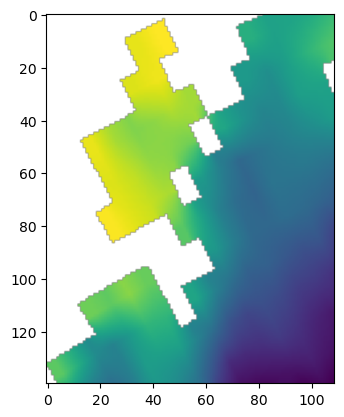

In [12]:
# img = mytile.data['cru_AnnualTimeSeries'][1970].dataset['tmax'].data[0]
img = mytile.data['cru_baseline']['tmax'].data[0]
# img = mytile.data['worldclim']['tmax'].data[0]

plt.imshow(img)

In [13]:
mytile.save('/media/rwspicer/data/V3/tem/03-tiles-testing', overwrite=True)

tmin
tmax
tavg
prec
srad
wind
vapr
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres
tmin
tmax
tmp
pre
dswrf
ugrd
vgrd
spfh
pres


In [21]:
variables = {
    'tmax': {'function': 'temperature', 'reference': 'tmax','baseline':'tmax', 'name': 'tmax'},
    'tmin': {'function': 'temperature', 'reference': 'tmin','baseline':'tmin', 'name': 'tmin'},
    'tavg': {'function': 'temperature', 'reference': 'tavg','baseline':'tmp', 'name': 'tavg'},
    'prec': {'function': 'precipitation', 'reference': 'prec','baseline':'pre', 'name': 'prec'},
}


mytile.calculate_correction_factors('cru_baseline', 'worldclim', variables)

In [23]:
mytile.data['correction_factors']


<xarray.Dataset> Size: 3MB
Dimensions:      (y: 140, x: 109, time: 12)
Coordinates:
  * y            (y) float64 1kB 3.393e+06 3.389e+06 ... 2.841e+06 2.837e+06
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * time         (time) int64 96B 1 32 60 91 121 152 182 213 244 274 305 335
    spatial_ref  int64 8B 0
Data variables:
    tmax         (time, y, x) float32 732kB nan nan nan ... 12.07 12.15 12.25
    tmin         (time, y, x) float32 732kB nan nan nan ... 17.85 17.93 18.02
    tavg         (time, y, x) float32 732kB nan nan nan ... 17.47 17.59 17.72
    prec         (time, y, x) float32 732kB nan nan nan ... 0.005227 0.005215

In [37]:
variables = {
    'tmax': {'function': 'temperature', 'temperature': 'tmax','correction_factor':'tmax', 'name': 'tmax'},
    'tmin': {'function': 'temperature', 'temperature': 'tmin','correction_factor':'tmin', 'name': 'tmin'},
    'tavg': {'function': 'temperature', 'temperature': 'tmp','correction_factor':'tavg', 'name': 'tavg'},
    'prec': {'function': 'precipitation', 'precipitation': 'pre','correction_factor':'prec', 'name': 'prec'},
}

year = 1970

self = mytile
source_id, correction_id ='cru_AnnualTimeSeries','correction_factors'

correction = self.data[correction_id]
source = self.data[source_id][year].dataset
temp = []
for var, info in variables.items():
    func = downscalers.LOOKUP[info['function']]
    current = func(source, correction, info)
    current.name = info['name']
    temp.append(current)
   
downscaled = xr.merge(temp)
downscaled


<xarray.Dataset> Size: 89MB
Dimensions:      (x: 109, y: 140, time: 365)
Coordinates:
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * y            (y) float64 1kB 3.393e+06 3.389e+06 ... 2.841e+06 2.837e+06
  * time         (time) object 3kB 1970-01-01 00:00:00 ... 1970-12-31 00:00:00
    spatial_ref  int64 8B 0
Data variables:
    tmax         (time, y, x) float32 22MB nan nan nan ... -7.998 -7.919 -7.829
    tmin         (time, y, x) float32 22MB nan nan nan ... -10.52 -10.43 -10.33
    tavg         (time, y, x) float32 22MB nan nan nan ... -9.961 -9.886 -9.801
    prec         (time, y, x) float32 22MB nan nan nan ... 2.317e-05 2.754e-05

In [15]:
from importlib import reload

from temds import annual
reload(annual)
from temds import downscaled
reload(downscaled)

<module 'temds.downscaled' from '/home/rwspicer/Desktop/tem/Input_production/src/temds/downscaled.py'>

In [24]:
variables = {
    'tmax': {'function': 'temperature', 'temperature': 'tmax','correction_factor':'tmax', 'name': 'tmax'},
    'tmin': {'function': 'temperature', 'temperature': 'tmin','correction_factor':'tmin', 'name': 'tmin'},
    'tavg': {'function': 'temperature', 'temperature': 'tmp','correction_factor':'tavg', 'name': 'tavg'},
    'prec': {'function': 'precipitation', 'precipitation': 'pre','correction_factor':'prec', 'name': 'prec'},
}
year = 1970
downscaled_list = []
for year in range(1970,1981):
    downscaled_list.append(
        downscaled.AnnualDaily(
            year, 
            mytile.downscale_year(
                year, 'cru_AnnualTimeSeries','cru_baseline', 'worldclim', variables
            )
        )
    )

parent
parent
parent
parent
parent
parent
parent
parent
parent
parent
parent


In [27]:
mytile.data.keys()

dict_keys(['worldclim', 'cru_AnnualTimeSeries', 'cru_baseline', 'correction_factors'])

In [28]:
downscaled_data = downscaled.AnnualTimeSeries(downscaled_list)

<class 'list'>
Checking Continuity (basic)
Data is continuous
Checking Continuity (advanced)
-- Checking 1970
-- Checking 1971
-- Checking 1972
-- Checking 1973
-- Checking 1974
-- Checking 1975
-- Checking 1976
-- Checking 1977
-- Checking 1978
-- Checking 1979
-- Checking 1980
Data is continuous


In [30]:
downscaled_data[1970].dataset

<xarray.Dataset> Size: 3MB
Dimensions:      (x: 109, y: 140, time: 12)
Coordinates:
  * x            (x) float64 872B -1.756e+06 -1.752e+06 ... -1.324e+06
  * y            (y) float64 1kB 3.393e+06 3.389e+06 ... 2.841e+06 2.837e+06
  * time         (time) int64 96B 1 32 60 91 121 152 182 213 244 274 305 335
    spatial_ref  int64 8B 0
Data variables:
    tmax         (time, y, x) float32 732kB nan nan nan ... -11.75 -11.86 -11.96
    tmin         (time, y, x) float32 732kB nan nan nan ... -17.54 -17.64 -17.72
    tavg         (time, y, x) float32 732kB nan nan nan ... -17.16 -17.29 -17.42
    prec         (time, y, x) float32 732kB nan nan nan ... 4.407 4.185 4.161

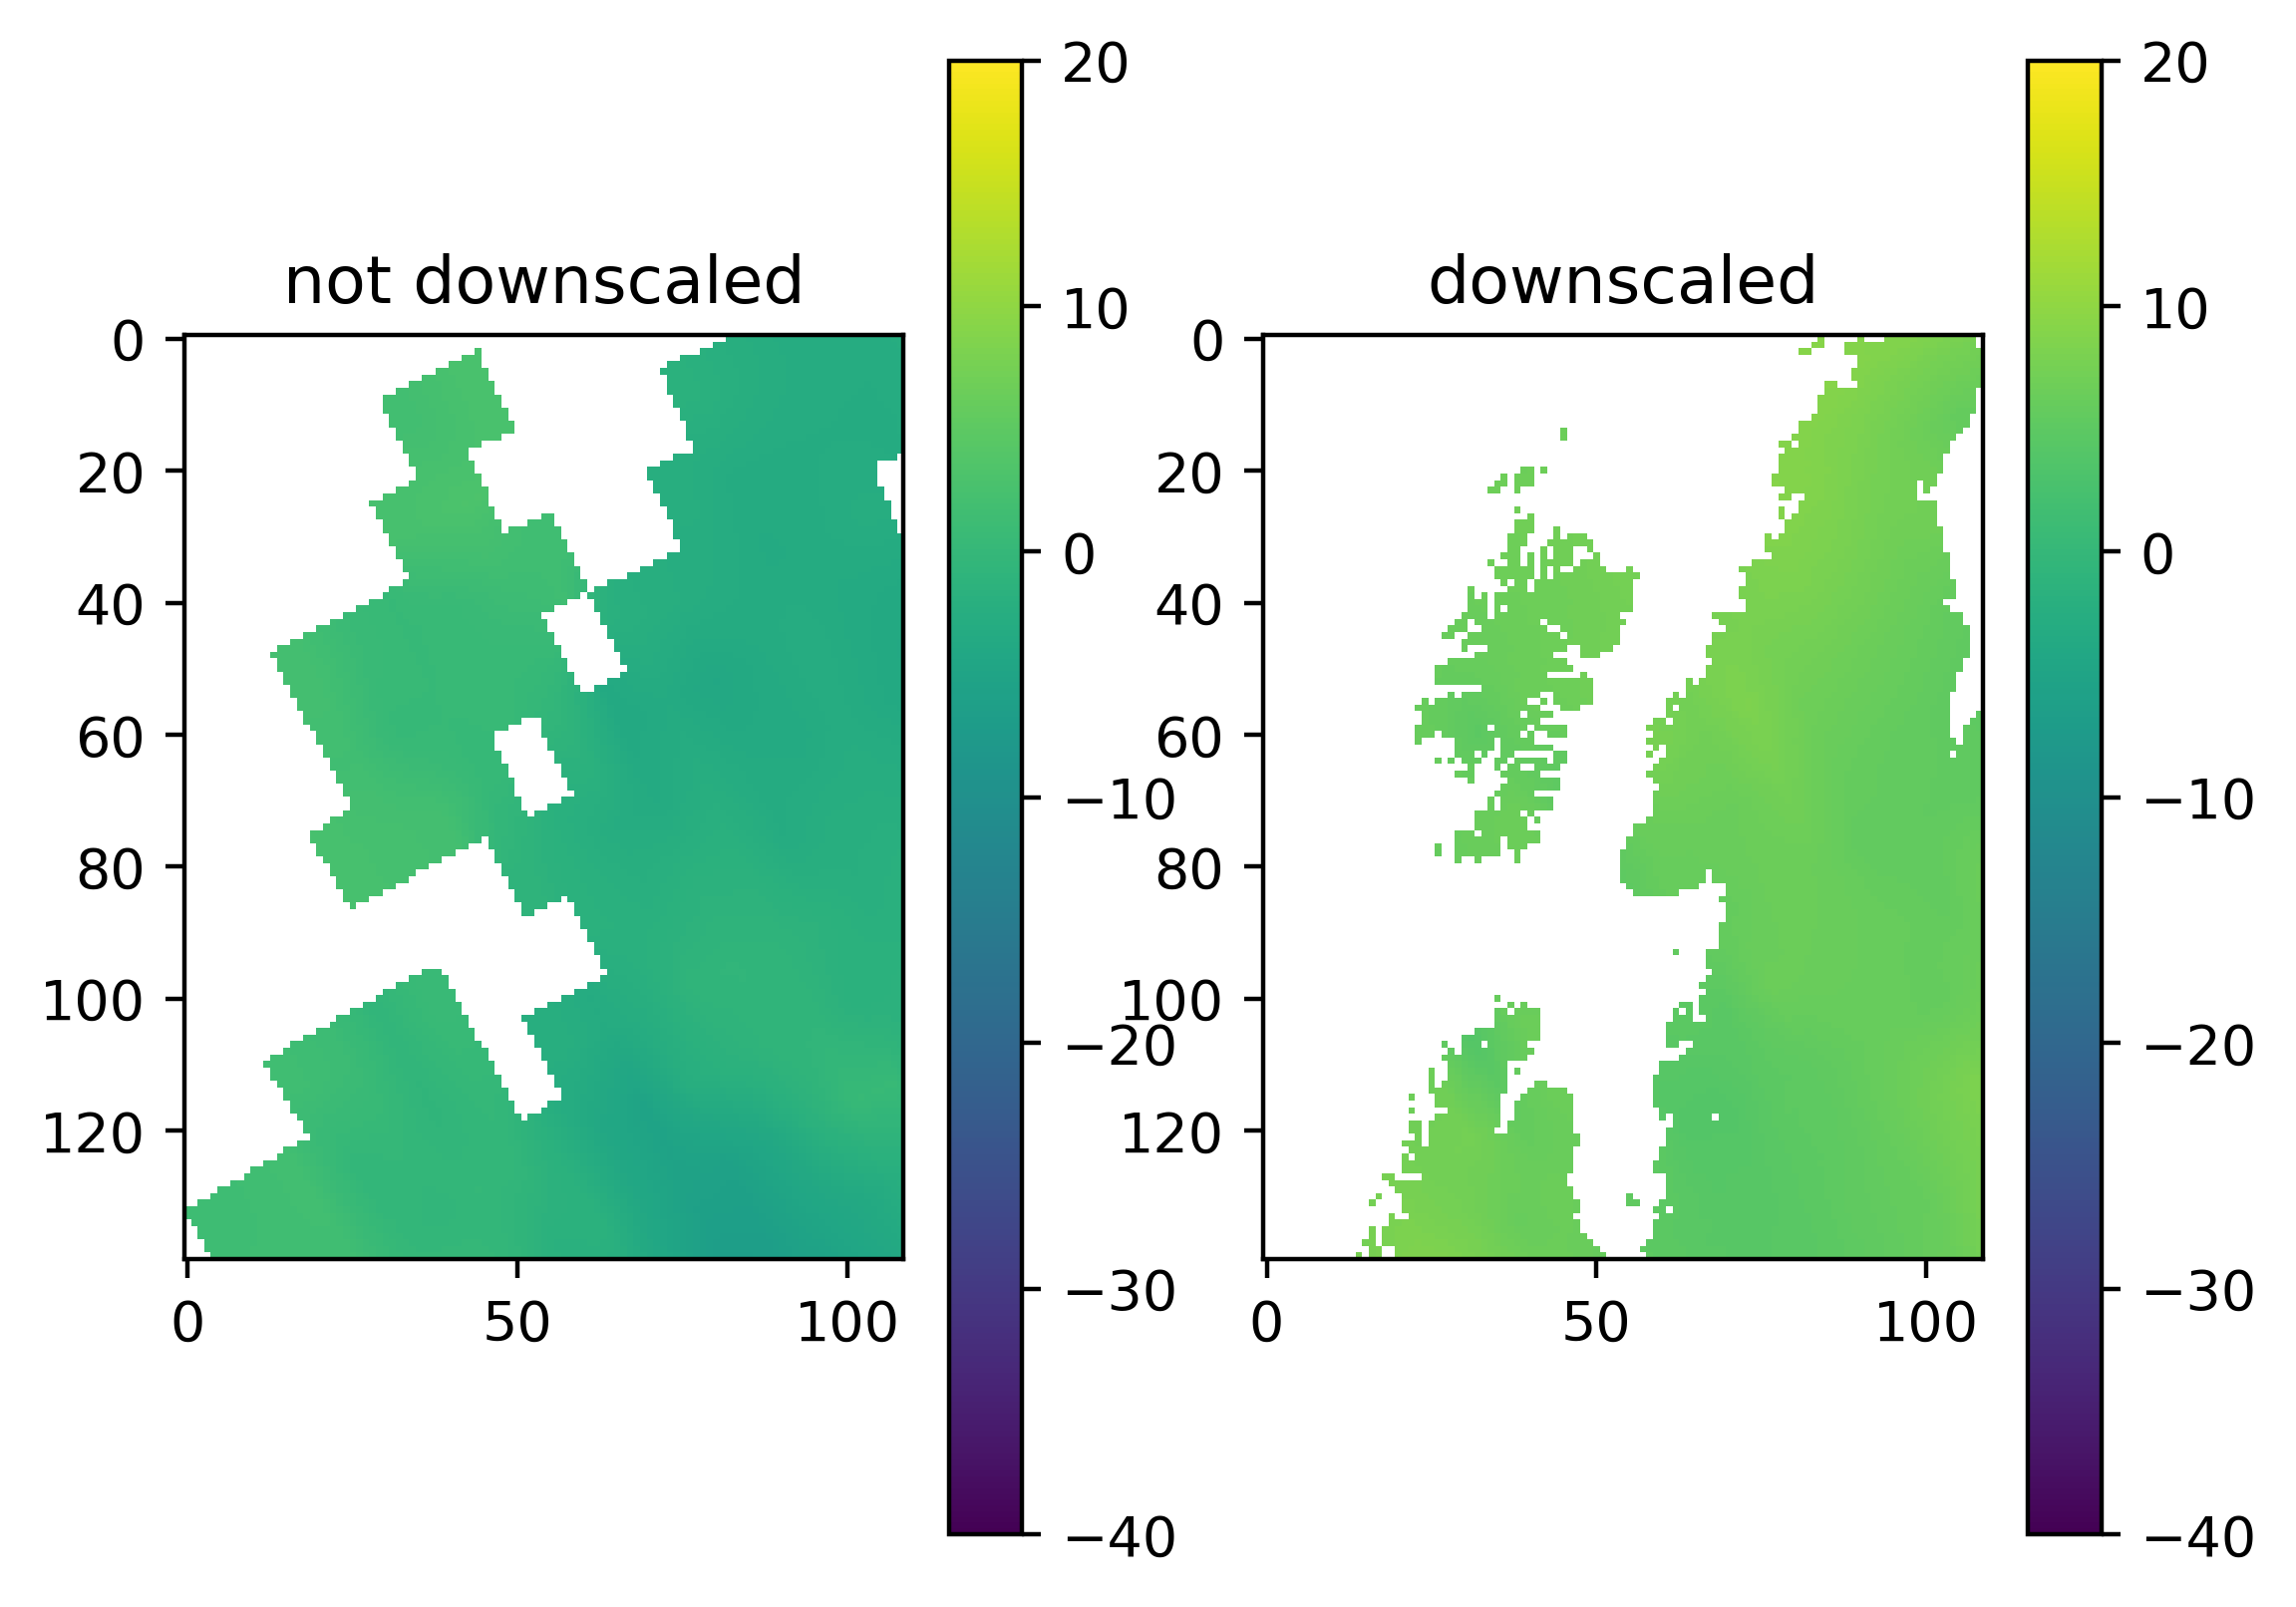

In [43]:
not_downscaled = mytile.data['cru_AnnualTimeSeries'][1970].dataset


fig, axes = plt.subplots(1,2, dpi=400)
axes[0].imshow(not_downscaled['tmax'].data[0] - corrections.ZERO_C_IN_K, vmin=-40, vmax=20)
axes[0].set_title('not downscaled')


im = axes[1].imshow(downscaled['tmax'].data[1], vmin=-40, vmax=20)
axes[1].set_title('downscaled')
fig.colorbar(im, ax=axes[1])
fig.colorbar(im, ax=axes[0])

plt.show()

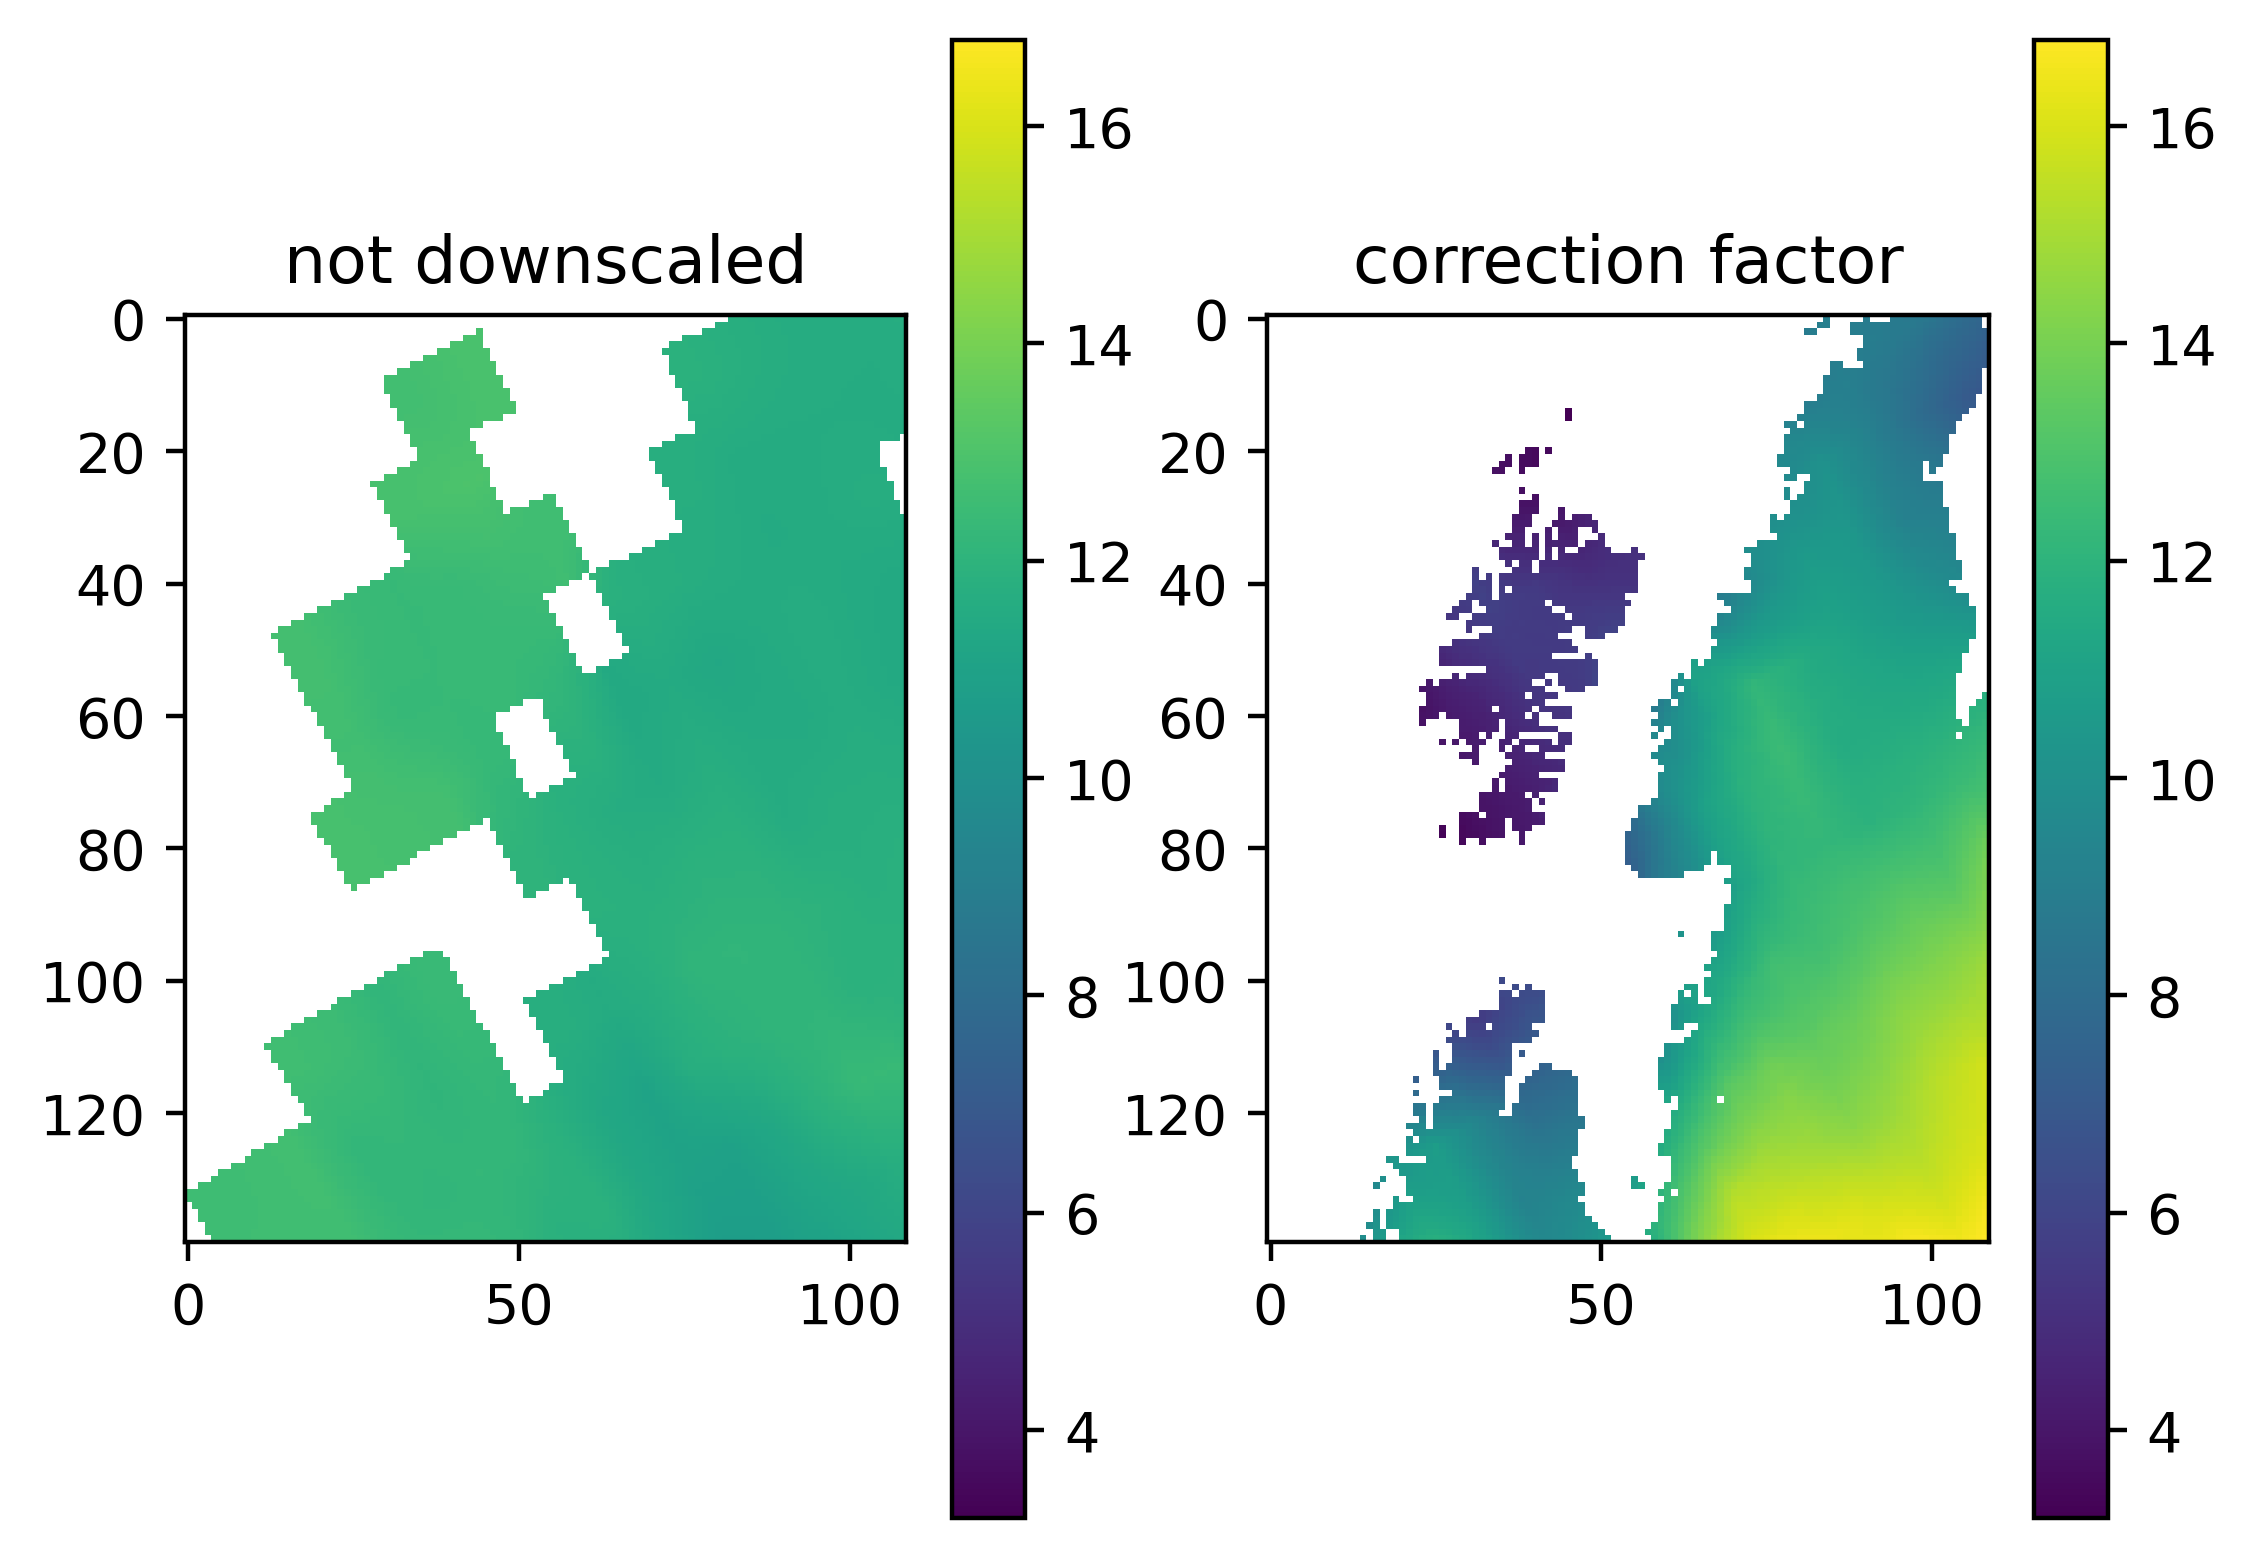

In [46]:
not_downscaled = mytile.data['cru_AnnualTimeSeries'][1970].dataset


fig, axes = plt.subplots(1,2, dpi=400)
axes[0].imshow(not_downscaled['tmax'].data[0] - corrections.ZERO_C_IN_K, vmin=-40, vmax=20)
axes[0].set_title('not downscaled')


im = axes[1].imshow(correction['tmax'].data[0])#, vmin=-40, vmax=20)
axes[1].set_title('correction factor')
fig.colorbar(im, ax=axes[1])
fig.colorbar(im, ax=axes[0])

plt.show()

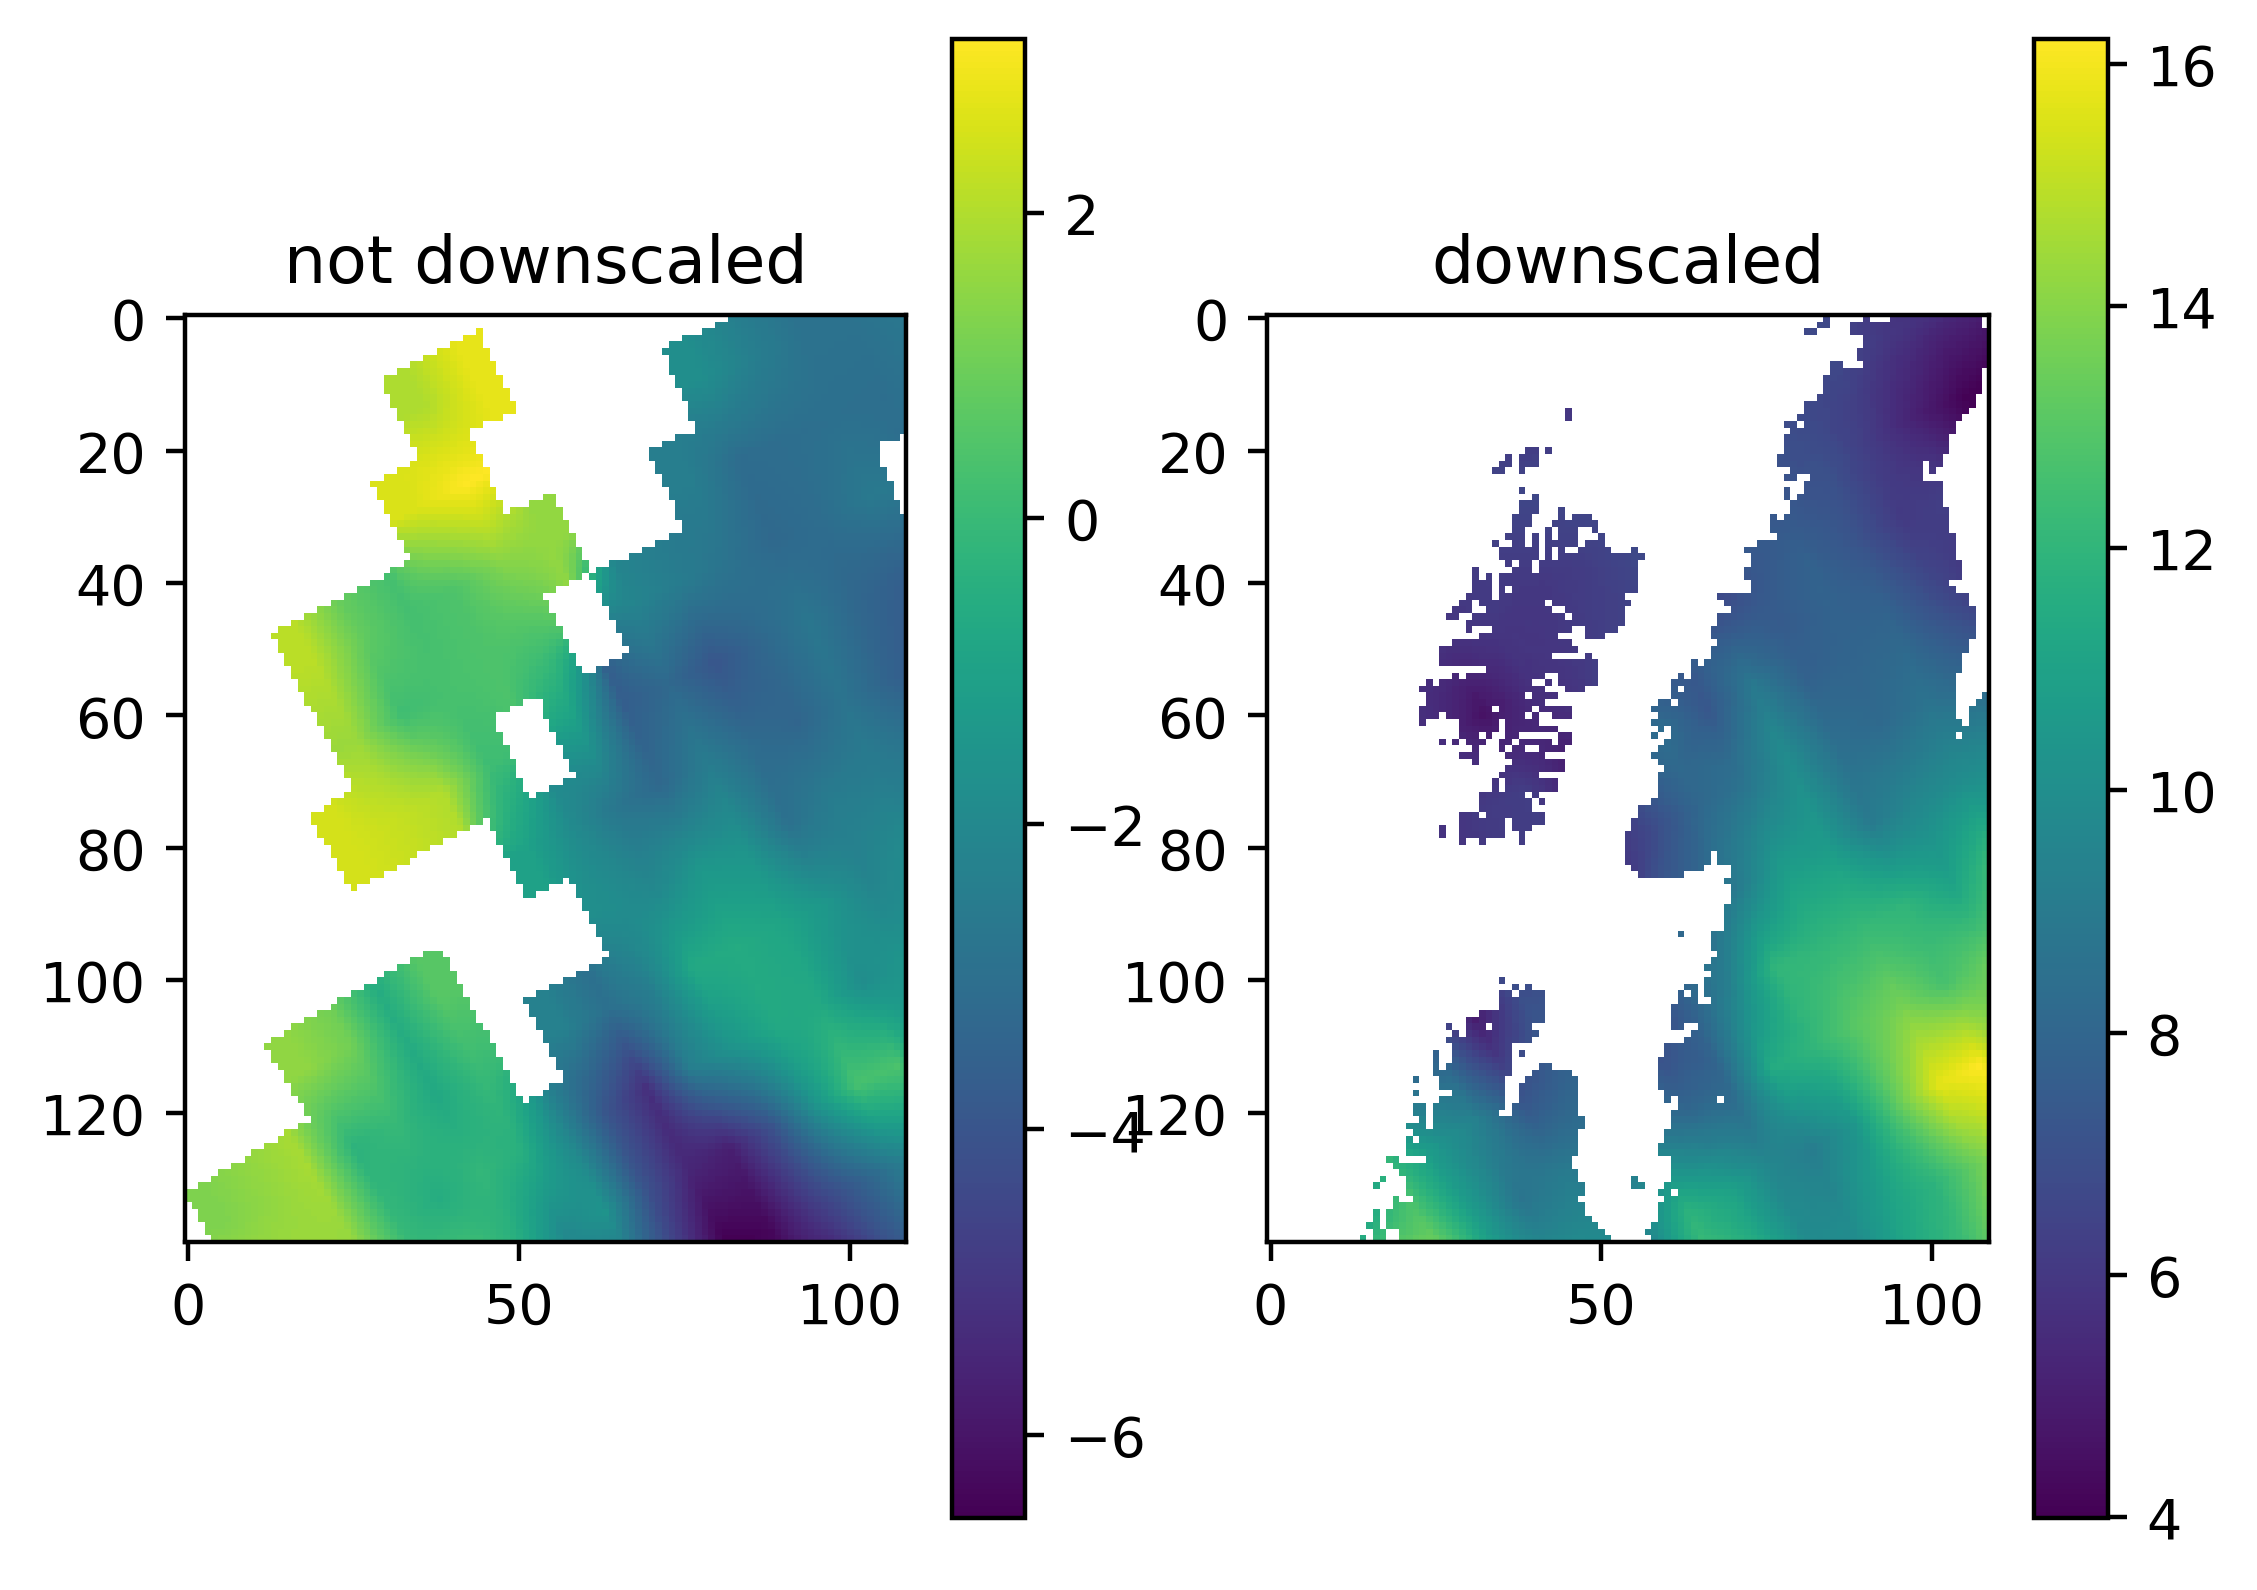

In [59]:
not_downscaled = mytile.data['cru_AnnualTimeSeries'][1970].dataset


fig, axes = plt.subplots(1,2, dpi=400)
im_0 = axes[0].imshow(not_downscaled['tmax'].data[0] - corrections.ZERO_C_IN_K)#, vmin=-40, vmax=20)
axes[0].set_title('not downscaled')


im = axes[1].imshow((not_downscaled['tmax'].data[0] - corrections.ZERO_C_IN_K) + correction['tmax'].data[0])#, vmin=-40, vmax=20)

axes[1].set_title('downscaled')
fig.colorbar(im, ax=axes[1])
fig.colorbar(im_0, ax=axes[0])

plt.show()

In [57]:
correction['tmax'].data[0]

array([[       nan,        nan,        nan, ...,  7.805074 ,  7.6935835,
               nan],
       [       nan,        nan,        nan, ...,  7.737539 ,  7.6274943,
               nan],
       [       nan,        nan,        nan, ...,  7.671028 ,  7.5629926,
         7.4549193],
       ...,
       [       nan,        nan,        nan, ..., 16.516228 , 16.599205 ,
        16.689297 ],
       [       nan,        nan,        nan, ..., 16.56392  , 16.649487 ,
        16.740067 ],
       [       nan,        nan,        nan, ..., 16.618103 , 16.704185 ,
        16.79701  ]], shape=(140, 109), dtype=float32)